In [ ]:
#default_exp models

In [ ]:
#export
from fastai.text.all import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Models
> Here we define the different models

## Utility layers
Simple functionalities for the models.

In [ ]:
def mask_normalisation(x, mask):
    "Normalises each trajectory without taking the mask into account"
    lens = x.shape[1] - mask.sum(dim=1) + 1
    x_with_0 = x.masked_fill(mask, 0)
    mean = x_with_0.sum(dim=1).div_(lens.type(x_with_0.type()))
    x_diff = (x - mean.unsqueeze(-1)).masked_fill(mask, 0)
    sd = x_diff.pow(2).sum(1).div(lens.type(x_with_0.type()) - 1).sqrt()
    return x_diff.div_(sd.unsqueeze(-1))

def mask_concat_pool(output, mask):
    "Pool output of RNN with padding mask into one tensor [last_pool, avg_pool, max_pool]"
    lens = output.shape[1] - mask.sum(dim=1) + 1
    out_with_0 = output.masked_fill(mask, 0)
    out_with_inf = output.masked_fill(mask, -float('inf'))
    avg_pool = out_with_0.sum(dim=1).div_(lens.type(out_with_0.type()))
    max_pool = out_with_inf.max(dim=1)[0]
    return torch.cat([output[:, -1], avg_pool, max_pool], 1)

def get_act(vocab_sz, yrange=None):
    "Provides activation according to regression or classification task."
    if vocab_sz == 1:
        yrange = (0, 2.05) if yrange is None else yrange
        act = SigmoidRange(*yrange)
    else:
        act = partial(F.softmax, dim=1)
    return act

## Model for baseline

The most basic model is one that takes the dataset and predicts the mean. Better start low, let's see what we get. 

In [ ]:
#export
class MeanPredict:
    def __init__(self):
        self.mean = 0
        
    def fit(self, y): self.mean = y.mean()
    def predict(self, x): return torch.ones(x.shape[0]) * self.mean

In [ ]:
#hide
from andi_unicorns.data import load_data

In [ ]:
df = load_data(task=1, dim=1)
x, y = df.loc[:, 'x'], df.loc[:, 'y']

In [ ]:
cut = int(x.shape[0]*0.2)
x_train, x_test = x[cut:], x[:cut]
y_train, y_test = y[cut:], y[:cut]

In [ ]:
mean_model = MeanPredict()
mean_model.fit(y_train)

In [ ]:
preds = mean_model.predict(x_test)
MAE = (tensor(y_test) - preds).abs().mean().item()
MAE

0.49662789702415466

## Baseline LSTM

Simplest possible LSTM to have a starting point. After the LSTM there's a (badly implemented) average pooling.

In [ ]:
#export
class SimpleLSTM(Module):
    "Cheap and simple LSTM running through the trajectories."
    def __init__(self, dim, h_size, vocab_sz, bs, n_layers=1, yrange=(0, 2.05)):
        self.rnn = nn.LSTM(dim, h_size, n_layers, batch_first=True)
        self.h_o = nn.Linear(h_size, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, h_size) for _ in range(2)] # In case we do a generative
        self.sigmoid = SigmoidRange(*yrange)
        
    def forward(self, x):
        res, h = self.rnn(x) # res[bs, len, h_size], 
        self.h = [h_.detach() for h_ in h]
        avg_pool = res.mean(1)   # Poorly done avg pooling
        out = self.h_o(avg_pool)
        return self.sigmoid(out).squeeze()
    
    def reset(self): 
        for h in self.h: h.zero_()

In [ ]:
#hide
from andi_unicorns.data import get_discriminative_dls

In [ ]:
bs = 512
dls = get_discriminative_dls(1, dim=1, bs=bs)
my_lstm = SimpleLSTM(dim=1, h_size=200, n_layers=2, vocab_sz=1, bs=bs)

In [ ]:
learn = Learner(dls, my_lstm, loss_func=L1LossFlat(), path=Path(".."))

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=1.5848932266235352)

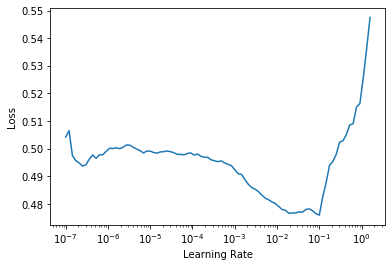

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.480675,0.457632,00:06
1,0.469124,0.455228,00:06
2,0.459526,0.455297,00:06
3,0.456676,0.458143,00:06
4,0.455993,0.452877,00:06
5,0.452940,0.450441,00:06
6,0.453736,0.451169,00:06
7,0.452826,0.452540,00:06
8,0.449670,0.453951,00:06
9,0.443756,0.438794,00:06


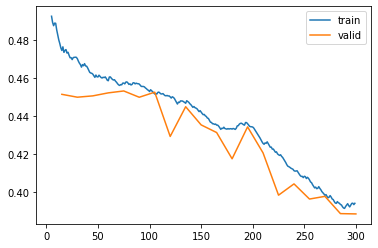

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('most_basic')

Path('models/most_basic.pth')

## LSTM with concat pooling
LSTM concatenating last, average and max pooling for the linear layer. Missing: dropout, RNN regularization and batch norm.

In [ ]:
#export
class ConcatPoolLSTM(Module):
    "LSTM with last, avg & max pooling."
    def __init__(self, dim, h_size, vocab_sz, n_layers=1, bidir=False, yrange=(0, 2.05), pad_value=0):
        self.pad_value = pad_value
        self.rnn = nn.LSTM(dim, h_size, n_layers, batch_first=True, bidirectional=bidir)
        self.h_o = nn.Linear(3*h_size, vocab_sz)
        self.sigmoid = SigmoidRange(*yrange)
        
    def forward(self, x):
        res, h = self.rnn(x)
        for h_ in h: h_.detach()
        mask = x == self.pad_value
        pool = mask_concat_pool(res, mask)
        out = self.h_o(pool)
        return self.sigmoid(out).squeeze()    

In [ ]:
#hide
from andi_unicorns.data import get_discriminative_dls

In [ ]:
bs = 256
dls = get_discriminative_dls(1, dim=1, bs=bs)
my_lstm = ConcatPoolLSTM(dim=1, h_size=200, vocab_sz=1, n_layers=2)

In [ ]:
learn = Learner(dls, my_lstm, loss_func=L1LossFlat(), path=Path(".."))

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=6.309573450380412e-07)

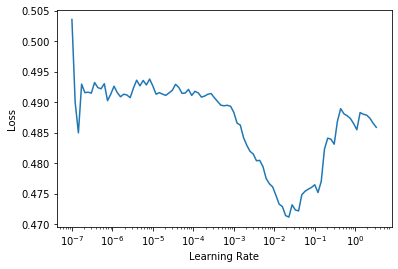

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=2e-3)

epoch,train_loss,valid_loss,time
0,0.477336,0.463557,00:05
1,0.453745,0.438139,00:05
2,0.441699,0.434306,00:05
3,0.433865,0.403646,00:05
4,0.410418,0.348553,00:05
5,0.380282,0.333734,00:05
6,0.357164,0.334694,00:05
7,0.343448,0.310950,00:05
8,0.329999,0.309211,00:05
9,0.320462,0.301743,00:04


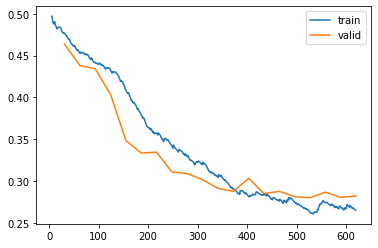

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('concat_pool')

Path('../models/concat_pool.pth')

## LSTM with regularization

Adding regularization to the previous model in the form of dropout and adding batch norm to the linear layers. 

In [ ]:
#export
class RegLSTMLin(Module):
    "LSTM with dropout and batch norm."
    def __init__(self, dim, h_size, vocab_sz=1, rnn_layers=1, in_p=0.4, hid_p=0.3, weight_p=0.5, out_ps=0.4, linear_layers=[200, 50], ps=None,   
                 bidir=False, yrange=(0, 2.05), pad_value=0):
        config = awd_lstm_clas_config
        self.pad_value = pad_value
        self.rnn = RegLSTM(dim, h_size, rnn_layers, hidden_p=hid_p, input_p=in_p, weight_p=weight_p, bidir=bidir)
        
        lin_dim = [h_size*3] + linear_layers + [vocab_sz]
        if ps is None: ps = [0.1]*len(linear_layers)
        ps = [out_ps] + ps
        self.linear = PoolingClassifier(lin_dim, ps=ps, yrange=yrange)
        
    def forward(self, x):
        mask = x == self.pad_value
        x = mask_normalisation(x, mask)
        out = self.rnn(x)
        x, _, _ = self.linear((out, mask))
        return x 
    
class RegLSTM(Module):
    "LSTM with regularization and inter-layer dropout."
    def __init__(self, dim, n_hid, n_layers, hidden_p=0.3, input_p=0.4, weight_p=0.5, bidir=False):
        store_attr('dim,n_hid,n_layers')
        self.n_dir = 2 if bidir else 1
        self.rnns = nn.ModuleList([self._one_rnn(dim if l == 0 else n_hid, n_hid//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, x):
        output = self.input_dp(x)
        new_hidden = []
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            output, new_h = rnn(output)
            new_hidden.append(new_h)
            if l != self.n_layers-1: output = hid_dp(output)
        self.hidden = to_detach(new_hidden, cpu=False, gather=False)
        return output

    def _one_rnn(self, n_in, n_out, bidir, weight_p, l):
        "Return one of the inner rnn"
        rnn = nn.LSTM(n_in, n_out, 1, batch_first=True, bidirectional=bidir)
        return WeightDropout(rnn, weight_p)
    
class PoolingClassifier(Module):
    "Pooling linear classifier inspired by `PoolingLinearClassifier`"
    def __init__(self, dims, ps, yrange=None):
        if len(ps) != len(dims)-1: raise ValueError(f"Number of layers {len(dims)} and dropout values {len(ps)} don't match.")
        acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
        layers = [LinBnDrop(i, o, p=p, act=a) for i,o,p,a in zip(dims[:-1], dims[1:], ps, acts)]
        layers.append(get_act(dims[-1], yrange=yrange))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        out, mask = x
        x = mask_concat_pool(out, mask)
        x = self.layers(x)
        return x, out, out

In [ ]:
#hide
from andi_unicorns.data import get_discriminative_dls, get_custom_dls

In [ ]:
dim = 1
bs = 256
dls = get_discriminative_dls(1, dim=1, bs=bs)
# dls = get_custom_dls(target='exp')
my_lstm = RegLSTMLin(dim=dim, h_size=500, rnn_layers=2, in_p=0., hid_p=0., weight_p=1e-4, out_ps=0.3, ps=[0.4, 0.4])

In [ ]:
learn = Learner(dls, my_lstm, loss_func=L1LossFlat(), path=Path(".."))

SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=7.585775847473997e-07)

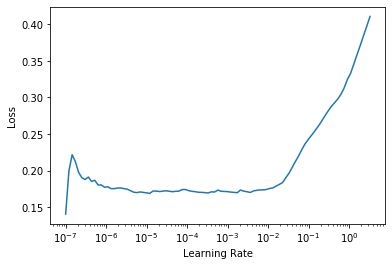

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-4, wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.173354,0.183362,01:35
1,0.164200,0.181294,01:36
2,0.177444,0.180776,01:36


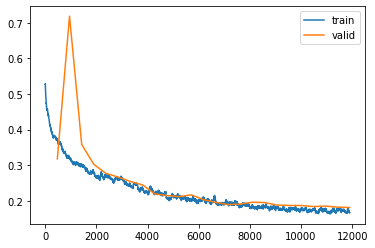

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save(f'reglstm_{dim}')

Path('../models/reglstm_1.pth')

In [ ]:
from andi_unicorns.data import validate_task

In [ ]:
learn.load(f'reglstm_{dim}')

In [ ]:
validate_task([learn.model.cuda()], 1, [1])

# Export-

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_models.ipynb.
Converted index.ipynb.
